In [1]:
C11 = 70.0136, -166.85755
C1 = 70.8357, -163.1044
C4 = 71.038916, -160.50353

from glob import glob
import numpy as np
from evFileProcessing import evFuncs # ev COM functions
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import urllib.request
import xarray as xr
import io
from tqdm.notebook import tqdm
def naive_fast(latvar,lonvar,lat0,lon0):
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:]
    lonvals = lonvar[:]
    ny,nx = latvals.shape
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min

filesD1Y1 = glob('../data/2018/EVFiles/DAFT1/exports/Loaded*.csv')
filesD1Y2 = glob('../data/2019/EVFiles/DAFT1/exports/Loaded*.csv')
filesD2Y1 = glob('../data/2018/EVFiles/DAFT2/exports/Loaded*.csv')
filesD2Y2 = glob('../data/2019/EVFiles/DAFT2/exports/Loaded*.csv')
filesD3Y2 = glob('../data/2019/EVFiles/DAFT3/exports/Loaded*.csv')
dfD1 = evFuncs.evExports.readEvExports(filesD1Y1+filesD1Y2)
dfD1.name = 'D1'
dfD2 = evFuncs.evExports.readEvExports(filesD2Y1+filesD2Y2)
dfD2.name = 'D2'
dfD3 = evFuncs.evExports.readEvExports(filesD3Y2)
dfD3.name = 'D3'

In [ ]:
import urllib.request
import xarray as xr
import io
url = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/north/daily/2017/seaice_conc_daily_nh_f17_20170801_v03r01.nc'
req = urllib.request.Request(url)
with urllib.request.urlopen(req) as resp:
    ds = xr.open_dataset(io.BytesIO(resp.read()))
ds

In [11]:
# Get the x,y for each mooring
url = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/north/daily/2017/seaice_conc_daily_nh_f17_20170801_v03r01.nc'
req = urllib.request.Request(url)
with urllib.request.urlopen(req) as resp:
    ds = xr.open_dataset(io.BytesIO(resp.read()))
iyC11,ixC11 = naive_fast(ds.latitude, ds.longitude, C11[0], C11[1])
iyC4,ixC4 = naive_fast(ds.latitude, ds.longitude, C4[0], C4[1])
iyC1,ixC1 = naive_fast(ds.latitude, ds.longitude, C1[0], C1[1])
ds.close()

In [44]:
# This is the function for the data requests
def buildNSIDCice(df, iy,ix,fnameOut=False):
    dates = df.datetime.map(lambda x: x.strftime('%Y%m%d')).astype(str).unique()
    iceC = []
    for date in tqdm(dates):
        url = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/north/daily/'+date[:4]+'/seaice_conc_daily_nh_f17_'+date+'_v03r01.nc'
        req = urllib.request.Request(url)
        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()))
        iceC.append(ds.seaice_conc_cdr[0,iy,ix].values)
        ds.close
    dfNew = pd.DataFrame({'datetime':dates,'iceC':iceC})
    if fnameOut==False:
        return dfNew
    else:
        dfNew.to_csv(fnameOut,index=False)
        return dfNew

In [ ]:
# Run the build
dfNew = buildNSIDCice(dfD3, iyC4, ixC4,'C4_NSIDC.csv')

In [58]:
dfIceC1 = pd.read_csv('../data/physicalData/C1_NSIDC2.csv')
dfIceC4 = pd.read_csv('../data/physicalData/C4_NSIDC2.csv')
dfIceC11 = pd.read_csv('../data/physicalData/C11_NSIDC2.csv')

<AxesSubplot:>

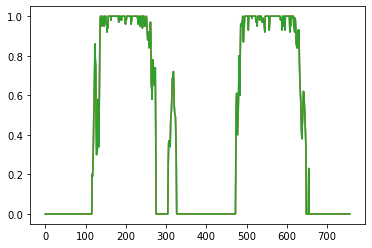

In [65]:
dfIceC1.iceC.plot()
dfIceC11.iceC.plot()
dfIceC4.iceC.plot()

# Make giant data file

In [7]:
from datetime import date, timedelta
startdate = date(int(2017), int(1), int(1))
s = []
while startdate < date(int(2020), int(1), int(1)):
    s.append(startdate)
    startdate += timedelta(days=1)

In [ ]:
# This is the function for the data requests

def buildNSIDCiceAll(dates, iy,ix,fnameOut=False):
    iceC = []
    for d in tqdm(dates):
        d = d.strftime('%Y%m%d')
        print(d)
        url = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02202_V3/north/daily/'+d[:4]+'/seaice_conc_daily_nh_f17_'+d+'_v03r01.nc'
        req = urllib.request.Request(url)
        with urllib.request.urlopen(req) as resp:
            ds = xr.open_dataset(io.BytesIO(resp.read()))
        iceC.append(ds.seaice_conc_cdr[0,iy,ix].values)
        ds.close
    dfNew = pd.DataFrame({'datetime':dates,'iceC':iceC})
    if fnameOut==False:
        return dfNew
    else:
        dfNew.to_csv(fnameOut,index=False)
        return dfNew

dates = s
buildNSIDCiceAll(dates,iyC11, ixC11,fnameOut='../data/physicalData/C11_NSIDC2.csv')